<a href="https://colab.research.google.com/github/vivri161803/LLM_From_Scratch/blob/main/Appendix_EfficientFineTuningWithLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter Efficient Fine-tuning con LoRA

## 💡 Cos'è l'ottimizzazione LoRA?

**LoRA (Low-Rank Adaptation)** è una tecnica di *Parameter-Efficient Finetuning* (PEFT) progettata per addestrare (o meglio, "adattare") in modo efficiente modelli linguistici di grandi dimensioni (LLM) e altri modelli pre-addestrati.

Invece di ri-addestrare *tutti* i miliardi di parametri del modello originale, LoRA **congela i pesi originali** (come $W$ nell'immagine) e introduce un numero molto piccolo di nuovi parametri addestrabili. Lo fa ipotizzando che l'aggiornamento necessario per adattare il modello a un nuovo compito (il $\Delta W$) abbia un "rango intrinseco basso" (low-rank).

In termini semplici, LoRA non modifica l'enorme modello originale, ma addestra solo un piccolo "adattatore" che si inserisce al suo fianco.

---

## ⚡ Il Vantaggio Computazionale

Il vantaggio principale di LoRA è un'enorme **riduzione delle risorse di calcolo e memoria** necessarie per il finetuning.

* **Finetuning Tradizionale:** Deve calcolare e memorizzare i gradienti e gli aggiornamenti ($\Delta W$) per *ogni singolo parametro* del modello. Se un modello ha 10 miliardi di parametri, deve addestrare 10 miliardi di parametri.
* **LoRA:** Addestra solo le matrici $A$ e $B$. La dimensione di queste matrici è definita dall'iperparametro $r$ (rank). Poiché $r$ è scelto molto più piccolo della dimensione originale $d$ (spesso $r$ è 8, 16, o 64, mentre $d$ è nell'ordine delle migliaia), il numero di parametri da addestrare è drasticamente inferiore.

Ad esempio, se la matrice dei pesi originali $W$ è $4096 \times 4096$ (circa 16.7 milioni di parametri), il finetuning tradizionale deve addestrare 16.7 milioni di parametri.
Con LoRA e un $r=8$, addestri solo due matrici $A$ ($8 \times 4096$) e $B$ ($4096 \times 8$). Il totale dei parametri addestrabili è $(8 \times 4096) + (4096 \times 8) \approx 65,000$, un numero **~256 volte più piccolo**!

Questo rende il finetuning accessibile anche su hardware con meno VRAM (come le GPU consumer) e accelera notevolmente il processo di addestramento.

---

## 🔬 Cosa Succede Tecnicamente (LaTeX)

L'obiettivo del finetuning è modificare i pesi pre-addestrati $W$ in $W' = W + \Delta W$, dove $\Delta W$ è la modifica appresa durante l'addestramento.

LoRA evita di calcolare direttamente $\Delta W$, che è una matrice "densa" (full-rank) e grande quanto $W$. Invece, approssima questo aggiornamento utilizzando due matrici di rango inferiore, $A$ e $B$.

$$
\Delta W \approx BA
$$

Dove:
* $W$ è la matrice dei pesi originale (es. $\mathbb{R}^{d \times k}$).
* $B$ è una matrice con $r$ colonne (es. $\mathbb{R}^{d \times r}$).
* $A$ è una matrice con $r$ righe (es. $\mathbb{R}^{r \times k}$).
* $r$ è il rango dell'adattamento ($r \ll d$ e $r \ll k$).

Durante l'addestramento, $W$ è **congelata** (non riceve gradienti). Solo $A$ e $B$ vengono aggiornate.

L'output del layer modificato $h$ per un input $x$ non è più $h = Wx$, ma diventa:

$$
h = Wx + (BA)x = Wx + B(Ax)
$$

Questo significa che l'output originale ($Wx$) viene calcolato come al solito, e ad esso viene sommato un "output di correzione" ($B(Ax)$) calcolato dalle piccole matrici $A$ e $B$.

Al momento dell'inferenza, i pesi possono essere uniti per efficienza (senza latenza aggiuntiva) calcolando $W' = W + BA$ una sola volta e salvando la nuova matrice $W'$.

---

## 🖼️ Descrizione dell'Immagine

L'immagine che hai fornito illustra perfettamente questo confronto:

* **A sinistra (Weight update in regular finetuning):** Mostra che per aggiornare i pesi pre-addestrati $W$, è necessario calcolare un "Weight update" $\Delta W$ che ha la stessa dimensione (indicata dalla $d$) di $W$. L'intero $\Delta W$ viene quindi aggiunto a $W$. Questo è costoso.
* **A destra (Weight update in LoRA):** Mostra un approccio diverso. I pesi pre-addestrati $W$ rimangono invariati. L'aggiornamento $\Delta W$ non viene calcolato direttamente, ma viene *approssimato* dal prodotto di due matrici molto più piccole, $A$ e $B$. L'immagine mostra come l'input $x$ passi attraverso $A$, venga ridotto a una dimensione interna $r$ (l'iperparametro), e poi passi attraverso $B$ per tornare alla dimensione originale prima di essere sommato all'output di $W$. Solo $A$ e $B$ vengono addestrate.

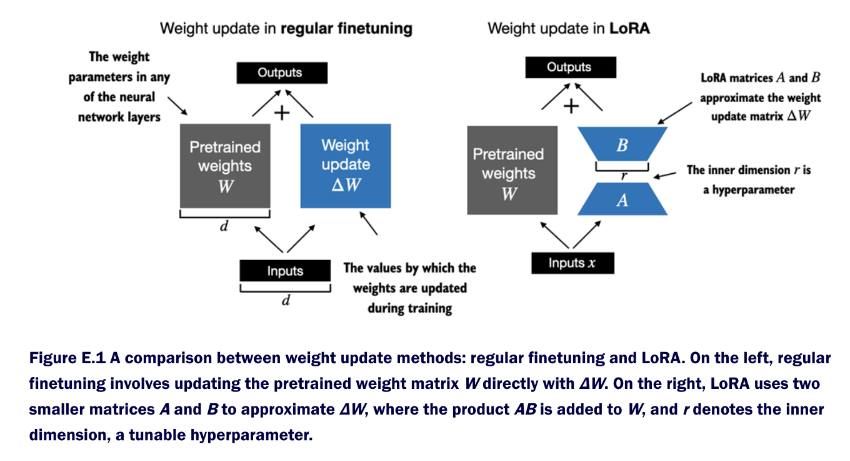

Nel corso di questa breve trattazione implementeremo solamente gli snippet di codice che permettono di utilizzare questa particolare tecnica. Non si daranno dimostrazioni del funzionamento, tuttavia il codice e direttamente compatibile con il resto, che viene fornito nei capitoli precedenti.

In [ ]:
import math
import torch

class LoRALayer(torch.nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
    # inizializzazione uguale a quella di base per i layer in Pytorch
    torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))

    self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
    self.alpha = alpha

  def forward(self, x):
    x = self.alpha*(x@self.A@self.B)
    return x

Questo layer `LoRALayer`, appena definito,
 corrisponde alla seconda parte dell'operazione di forward che, secondo LoRA, viene riscritta come:
$$h = W'x = (W + ΔW) x = (W + AB)x = Wx + ABx = \text{model}(x) + \text{LoRALayer}(x)$$

In [ ]:
# operazione completa
class LinearWithLoRA(torch.nn.Module):
  def __init__(self, linear, rank, alpha):
    self.linear = linear
    self.lora = LoRALayer(linear.in_features, linear.out_features, rank, alpha)

  def forward(self, x):
    return self.linear(x) + self.lora(x) # h = xW + xAB

In [ ]:
# applicazione ad un vecchio modello con layer lineari senza LoRA
def replace_linear_with_lora(model, rank, alpha):
  for name, module in model.named_children():
    if isinstance(module, torch.nn.Linear):
      setattr(model, name, LinearWithLoRA(module, rank, alpha))
    else:
      replace_linear_with_lora(module, rank, alpha)

L'implementazione ricorsiva assume sinificato nel momento in cui si pensa che architetture complesse, come quella dei transformer, prevedono una struttura modulare, formata sia da layer lineari che non (vd. causal attention, GELU activation). Applicare ricorsivamente a funzione a tutti i moduli permette di essere sicuri di aver sostituito tutti i layer lineari presenti nel modello con nuovi `LinearWithLoRA`

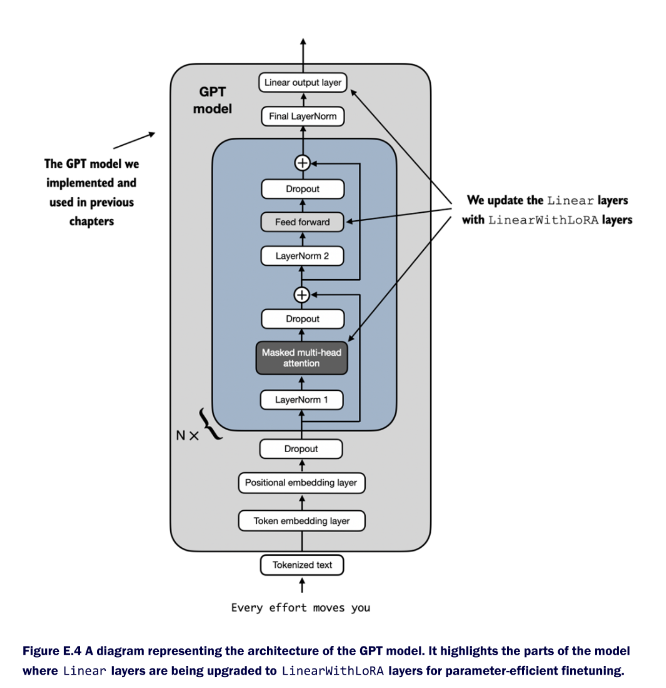

### Modello GPT-Like
Questo e li codice che implementa questo modello:

In [ ]:
import torch.nn as nn

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 # per evitare di dividere per zero
    self.scale = nn.Parameter(torch.ones(emb_dim)) # parametri aggiuntivi allenabili
    self.shift = nn.Parameter(torch.zeros(emb_dim)) # parametri aggiunti allenabili

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale * x + self.shift # operazioni elemento per elemento

In [ ]:
# trasformer block
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]
    )

    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x

    # attention module
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    # feed-forward network
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x) # linear layer --> GELU --> linear layer
    x = self.drop_shortcut(x)
    x = x + shortcut # residual connection

    return x

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5*x*(1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) *
        (x+0.044715*torch.pow(x,3))
    ))

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):

    super().__init__()
    assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
    self.d_in = d_in
    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads

    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # linear layer to combine head outputs

    self.dropout = nn.Dropout(dropout) # layer di dropout

    self.register_buffer(
    'mask',
    torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    b, num_tokens, d_in = x.shape
    # [b, num_tokens, d_out]
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    # [b, num_tokens, num_heads, head_dim]
    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
    values = values.view(b, num_tokens, self.num_heads, self.head_dim)
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    # [b, num_heads, num_tokens, head_dim]
    keys = keys.transpose(1, 2)
    queries = queries.transpose(1, 2)
    values = values.transpose(1, 2) # Q
    attn_scores = queries @ keys.transpose(2, 3) # K^T

    # causal masking
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
    attn_scores.masked_fill_(mask_bool, -torch.inf)

    # normalization
    attn_weights = torch.softmax(
      attn_scores / keys.shape[-1]**0.5, dim=-1
    )

    # droput regularization
    attn_weights = self.dropout(attn_weights)
    context_vec = (attn_weights @ values).transpose(1, 2)

    # output factorization: [b, num_tokens, num_heads*head_dim]]
    context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out) # Z

    # proiezione addizionale facoltativa
    context_vec = self.out_proj(context_vec)

    return context_vec

In [ ]:
class GPTModel(nn.Module):

  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
    self.drop_emb = nn.Dropout(cfg['drop_rate'])

    self.trf_blocks = nn.Sequential(
          *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm = LayerNorm(cfg['emb_dim'])
    self.out_head = nn.Linear(
        cfg['emb_dim'], cfg['vocab_size'], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_length = in_idx.shape

    # creazione token di input con poitional encoding
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_length, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds

    # dropout layer
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257, # used by the BPE tokenizer
    "context_length" : 1024,
    "emb_dim" : 768, # each input token is transformed in a 768-dimensional embedding
    "n_heads" : 12, # number of attention-heads in multi-head-attention mechanism
    "n_layers" : 12,
    "drop_rate" : 0.1, # dropout regularization
    "qkv_bias" : False # query-key-value bias
}

In [ ]:
model = GPTModel(GPT_CONFIG_124M)

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: ", total_params)

### Demo

Poi dobbiamo congelare il valore dei parametri del foundation model, in maniera tale, durante il fine-tuning, ci si concentri solamente sui parametri del layer LoRA.

In [ ]:
# codice isolato
for param in model.parameters():
  param.requires_grad = False

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: ", total_params)

In [ ]:
replace_linear_with_lora(model, rank = 16, alpha = 16)

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: ", total_params)

Come si puo vedere i parametri allenabili sono molti meno.

In [ ]:
print(model)